In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

from feature_extraction.beats_extractor import load_models as load_beats, preprocess_audio, extract_beats_features
from feature_extraction.clip_extractor import initialize_clip_model, extract_clip_features, save_clip_features
from scipy.io import savemat
import pathlib
import numpy as np

# load the audio model
BEATs_tokenizer, BEATs_model = load_beats()

# preprocess audio
waveform, sr = preprocess_audio("../rest_audio.wav")  # assumes rest_audio.wav in project root

# extract beats features averaged per second
features_per_sec, labels = extract_beats_features(waveform, BEATs_tokenizer, BEATs_model, sample_rate=sr)

# save audio features
savemat("features_per_sec.mat", {"features_per_sec": features_per_sec})

# load CLIP model
processor, vision_model = initialize_clip_model()

# extract frame numbers from saved frames
frames_dir = "../feature_extraction/frames"  # confirmed working path
import cv2
video_path = "../movie.mp4"
cap = cv2.VideoCapture(video_path)
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
total_seconds = int(np.ceil(frame_count / fps))

frame_indices = np.arange(total_seconds)


# extract CLIP features for all frames
clip_features = extract_clip_features(frames_dir, frame_indices, processor, vision_model)

# save vision features
save_clip_features(clip_features, "vision_clip_features.mat")


/opt/conda/envs/pytorch-dev/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
366it [00:30, 11.85it/s]                                                        
Extracting CLIP features: 100%|█████████████| 3655/3655 [04:14<00:00, 14.37it/s]

Final CLIP feature shape: (3655, 768)
Saved features to vision_clip_features.mat


In [9]:
# load features from mat files
import scipy.io as sio

Audio_path = "features_per_sec.mat"
Vision_path = "vision_clip_features.mat"

data_audio = sio.loadmat(Audio_path)['features_per_sec']
data_vision = sio.loadmat(Vision_path)['features']

data_audio.shape, data_vision.shape


((3655, 768), (3655, 768))

In [10]:
data = np.concatenate((data_audio, data_vision), axis=1)
print('Feature space dimensions:', data.shape)

Feature space dimensions: (3655, 1536)


In [4]:
# Load Brain data
LH_path = '../notmean_left_Meanfile.mat'
RH_path = '../notmean_right_Meanfile.mat'

data_LH = sio.loadmat(LH_path)['Left_data']
data_RH = sio.loadmat(RH_path)['Right_data']

data_RH.shape, data_LH.shape

((32492, 3655), (32492, 3655))

In [5]:
brain = np.concatenate((data_LH, data_RH), axis=0)
brain = brain.transpose()

print('Brain data dimensions:', brain.shape)

Brain data dimensions: (3655, 64984)


In [6]:
# Normalize data
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / (std + 1e-8) 
    print(f"std.min = {std.min()}, std.max = {std.max()}")
    if std.any() == 0:
        print("Warning: Standard deviation is zero for some features, normalization may not be effective.")
    return normalized_data

data = normalize_data(data)
brain = normalize_data(brain)

std.min = 0.012566308490931988, std.max = 1.6923041343688965
std.min = 0.0, std.max = 1.3306655238461678


In [7]:
window_length = 10

def create_training_data(data, activity, window_length):
    time = data.shape[0]

    x = []
    y = []

    for i in range(time - window_length):
        window = data[i:i + window_length, :]
        x.append(window.reshape(-1))
        y.append(activity[i + window_length - 1])

    return x, y

In [8]:
data_windows, activity = create_training_data(data, brain, window_length)

print('Data windows shape:', np.array(data_windows).shape)
print('Activity shape:', np.array(activity).shape)

Data windows shape: (3645, 15360)
Activity shape: (3645, 64984)


In [8]:
# # Shuffle the data
# indices = np.arange(len(data_windows))
# np.random.shuffle(indices)
# data_windows = np.array(data_windows)[indices]
# activity = np.array(activity)[indices]

In [9]:
# Split data
data_windows = np.array(data_windows)
activity = np.array(activity)

train_data = data_windows[:int(0.8 * len(data_windows))]
train_activity = activity[:int(0.8 * len(activity))]

test_data = data_windows[int(0.8 * len(data_windows)):]
test_activity = activity[int(0.8 * len(activity)):]

print('Train data shape:', train_data.shape)
print('Train activity shape:', train_activity.shape)
print('Test data shape:', test_data.shape)
print('Test activity shape:', test_activity.shape)

Train data shape: (2916, 15360)
Train activity shape: (2916, 64984)
Test data shape: (729, 15360)
Test activity shape: (729, 64984)


In [10]:
# apply linear model
from sklearn.linear_model import LinearRegression
import joblib
from tqdm import tqdm

In [11]:
model = LinearRegression()
model.fit(train_data, train_activity)

LinearRegression()

In [12]:
weights = model.coef_
print("Weights shape:", weights.shape) 

weights = weights.reshape(64984, window_length, -1)

avg_weights = np.mean(weights, axis=0)
avg_weights.shape

Weights shape: (64984, 15360)


(10, 1536)

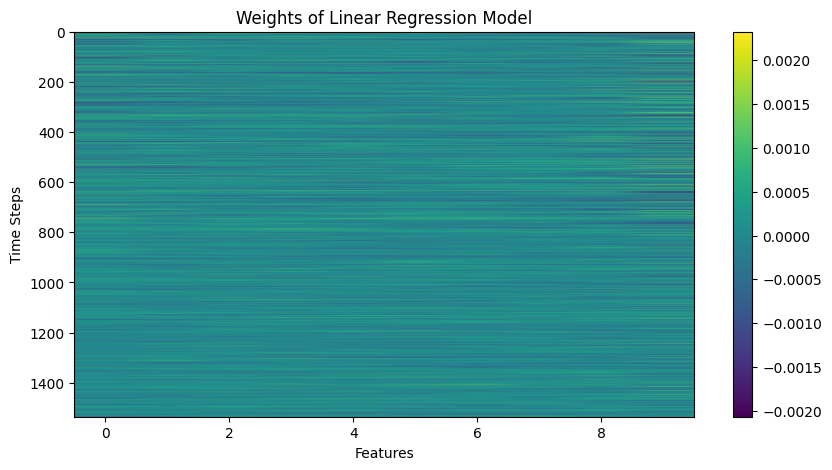

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(avg_weights.transpose(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Weights of Linear Regression Model')
plt.xlabel('Features')
plt.ylabel('Time Steps')
plt.show()

In [14]:
# get r values of correlation
from scipy.stats import pearsonr
def calculate_r_values(predicted, activity):
    r_values = []
    for i in range(activity.shape[1]):
        r, _ = pearsonr(predicted[:, i], activity[:, i])
        r_values.append(r)
    return np.array(r_values)
predicted = model.predict(test_data)
r_values = calculate_r_values(predicted, test_activity)

/var/tmp/ipykernel_49396/2668401243.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(predicted[:, i], activity[:, i])


In [15]:
r_values

array([0.13247518, 0.41478219, 0.19762516, ..., 0.2240689 , 0.16653944,
       0.13433295], shape=(64984,))

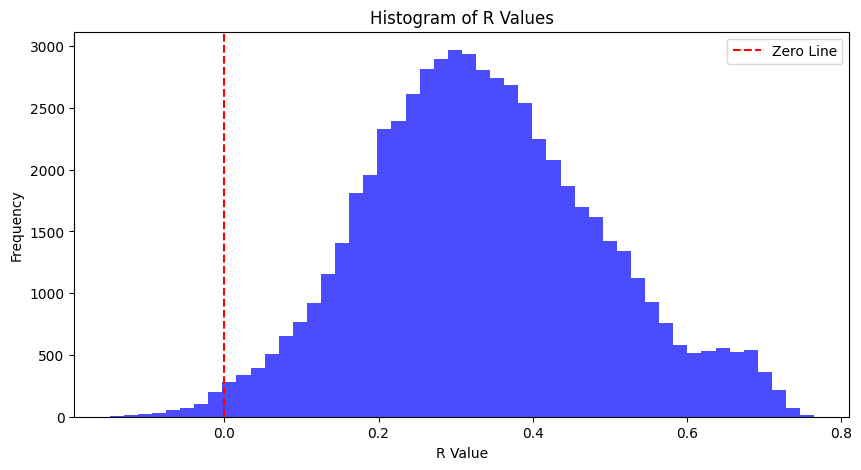

In [16]:
# plot histogram of r values
plt.figure(figsize=(10, 5))
plt.hist(r_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of R Values')
plt.xlabel('R Value')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line')
plt.legend()
plt.show()

In [17]:
r_LH = r_values[0:32492]
r_RH = r_values[32492:]

r_LH.shape, r_RH.shape

((32492,), (32492,))

In [18]:
import nibabel as nib
import numpy as np

data_array = nib.gifti.GiftiDataArray(np.float32(r_LH))
gifti_img = nib.gifti.GiftiImage(darrays=[data_array])
file_path = 'r_values.LH.func.gii'
nib.save(gifti_img, file_path)

data_array = nib.gifti.GiftiDataArray(np.float32(r_RH))
gifti_img = nib.gifti.GiftiImage(darrays=[data_array])
file_path = 'r_values.RH.func.gii'
nib.save(gifti_img, file_path)